### Preparing Environment

In [1]:
# Load required librairies.
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#allows plots to be printed withouth plt.show() command
%matplotlib inline 


# Display n rows from pandas outputs
pd.options.display.max_rows = 4000

# pip install --upgrade matplotlib

In [2]:
# Load rental data.
rentals = pd.io.parsers.read_csv('zillow_sales.csv', dtype={'RegionName': 'str'})
rentals = rentals[["RegionName", "2021-06"]]

### Loading and processing data

In [3]:
# Load sales data
sales = pd.io.parsers.read_csv('zillow_rentals.csv', dtype={'RegionName': 'str'})
sales = sales[["RegionName", "State", "City", "Metro", "CountyName","2021-06-30"]]

In [4]:
# Load income data
# Income Tax by zipcode from IRS, located - https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2018-zip-code-data-soi
# "zipcode" is the zipcode, column "N1" is the number of returns and A00100 is adjusted gross income, A02650 is total income, and A00200 is salaries and wages.
income = pd.io.parsers.read_csv('18zpallagi.csv', dtype={'zipcode': 'str'})

In [5]:
# Process income data for joining
income = income[["zipcode","N1","A00100","A02650","A00200"]]
income = income.groupby("zipcode").sum()
income["gincome"] = income["A00100"]/income["N1"]*1000
income["tincome"] = income["A02650"]/income["N1"]*1000
income["salwag"] = income["A00200"]/income["N1"]*1000
income["RegionName"] = income.index
income = income[["gincome","tincome","salwag","RegionName"]]

In [6]:
# Merge Rentals and Sales Tables
dataset = pd.merge(sales, rentals, how="inner", on="RegionName")

In [7]:
# Merge Income with main dataset
dataset = pd.merge(dataset, income, how="inner", on="RegionName")

In [8]:
#Rename columsn for main dataset
dataset.columns = ('zip','state','city','metro','county','sale','rent','gross','total','wage')

In [9]:
# Add column for rent to sales ratio
dataset["rs"] = dataset["rent"] / dataset["sale"]

In [10]:
# Add column for income to rent ratio
dataset["ir"] = dataset["gross"] / dataset["rent"]

In [11]:
# Remove all records with any null values
dataset = dataset.dropna()

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708 entries, 0 to 1738
Data columns (total 12 columns):
zip       1708 non-null object
state     1708 non-null object
city      1708 non-null object
metro     1708 non-null object
county    1708 non-null object
sale      1708 non-null float64
rent      1708 non-null float64
gross     1708 non-null float64
total     1708 non-null float64
wage      1708 non-null float64
rs        1708 non-null float64
ir        1708 non-null float64
dtypes: float64(7), object(5)
memory usage: 173.5+ KB


In [13]:
dataset.describe()

,sale,rent,gross,total,wage,rs,ir
count,1.708000e+03,1708.000000,1.708000e+03,1.708000e+03,1708.000000,1708.000000,1708.000000
mean,5.352053e+05,1895.194965,1.011725e+05,1.023935e+05,64762.734113,0.004486,51.945078
std,4.083440e+05,639.113152,8.506985e+04,8.605913e+04,34973.942061,0.001800,32.660755
min,5.813900e+04,783.000000,2.520168e+04,2.539657e+04,14443.750000,0.000946,11.574329
25%,2.879260e+05,1513.500000,5.445871e+04,5.492282e+04,41620.325464,0.003231,32.937083
50%,4.072260e+05,1774.500000,7.654465e+04,7.750221e+04,55270.910941,0.004249,42.781671
75%,6.350732e+05,2171.500000,1.134598e+05,1.148752e+05,76237.203508,0.005600,59.169979
max,4.128071e+06,14102.000000,1.265223e+06,1.271257e+06,399420.212766,0.019557,323.471964


### Evaluating Data Before Modeling

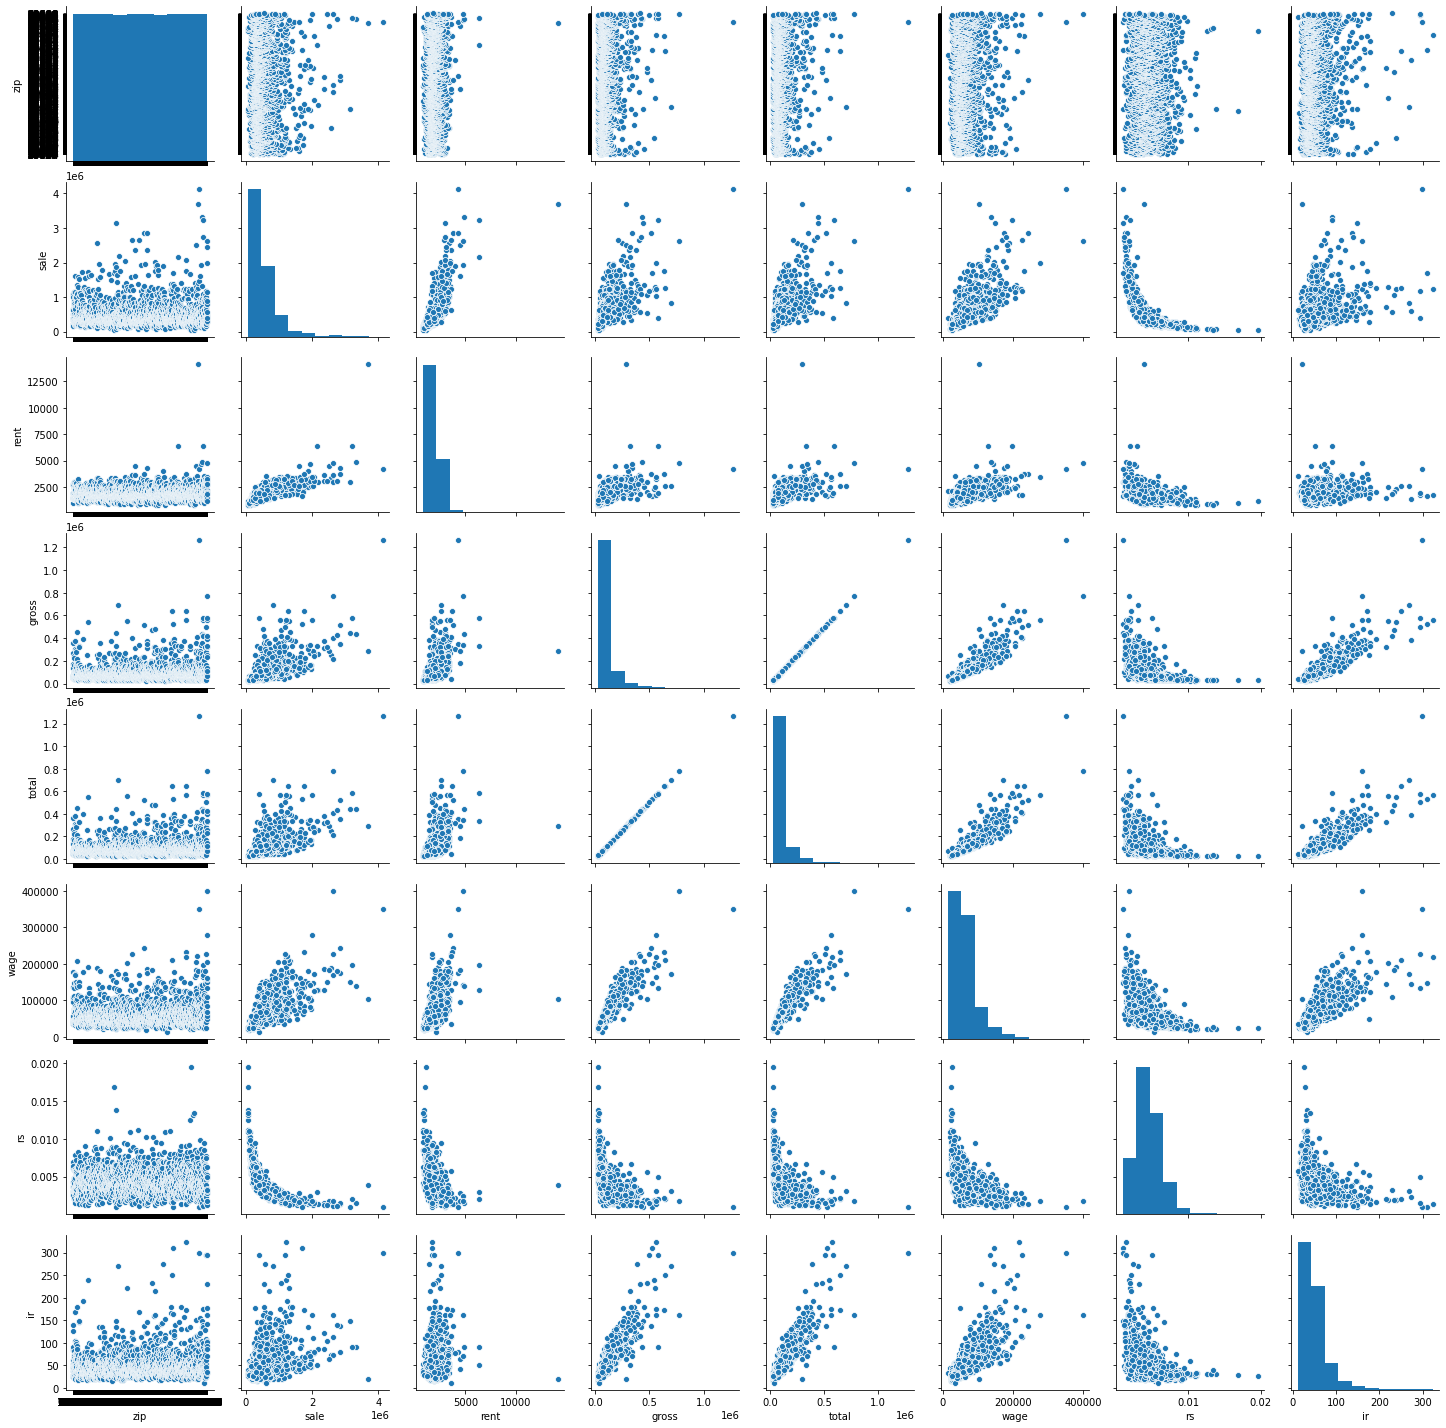

In [14]:
sns.pairplot(dataset)

<AxesSubplot:xlabel='rs'>

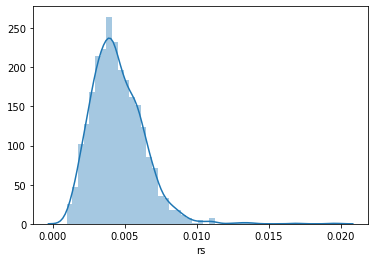

In [15]:
sns.distplot(dataset['rs'])

<AxesSubplot:>

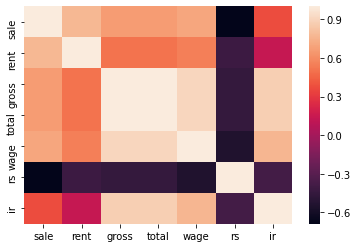

In [16]:
sns.heatmap(dataset.corr())

### Training Model

In [17]:
X = dataset[['wage','sale']]

y = dataset['rent']

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
lm = LinearRegression()

In [22]:
lm.fit(X_train,y_train)

LinearRegression()

In [23]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
wage,-0.000886
sale,0.001331


In [24]:
predictions = lm.predict(X_test)

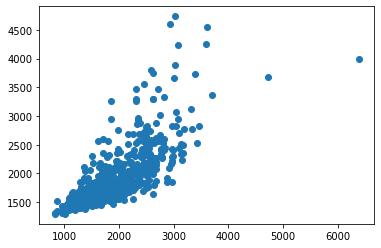

In [25]:
plt.scatter(y_test,predictions)

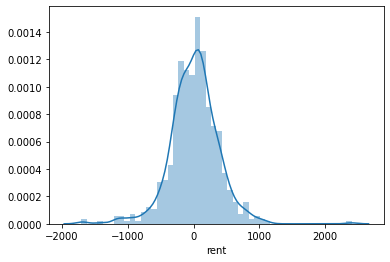

In [26]:
sns.distplot((y_test-predictions),bins=50);

In [27]:
from sklearn import metrics

In [28]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('r2:', metrics.r2_score(y_test, predictions))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, predictions))

MAE: 270.3702678794456
MSE: 136864.04965589536
RMSE: 369.95141526407946
r2: 0.5431707679150943
MAPE: 0.1426662517036246


### Clustering

In [29]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [30]:
kmeans = KMeans(n_clusters=4)

In [68]:
data = np.array(dataset[["rent","wage"]])
data

array([[  2820.        , 104194.29189189],
       [  1623.        ,  96689.23227864],
       [  2807.        , 178245.10650547],
       ...,
       [  2656.        , 157801.99203187],
       [  2783.        , 161527.63636364],
       [  1815.        , 108182.30769231]])

In [62]:
kmeans.fit(data)

KMeans(n_clusters=4)

In [63]:
kmeans.labels_

array([2, 2, 1, ..., 1, 1, 2])

In [64]:
kmeans.cluster_centers_

array([[  1645.99666667,  42195.31171378],
       [  3090.        , 196257.53904239],
       [  2430.20418848, 117992.16284617],
       [  2014.6451049 ,  72151.88280228]])

IndexError: too many indices for array

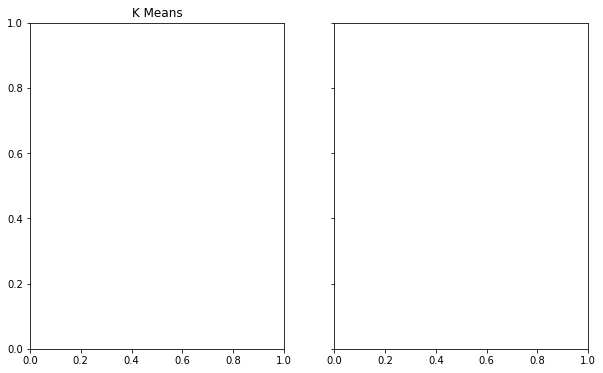

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
ax1.set_title('K Means')
ax1.scatter(data[0][:,0],data[0][:,1],c=kmeans.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(data[0][:,0],data[0][:,1],c=data[1],cmap='rainbow')